In [1]:
import numpy as np
print(np.__version__)
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import os 
print(tf.__version__)
print(tfio.__version__)
import matplotlib.pyplot as plt

1.23.1
2.10.0
0.27.0


In [2]:
physical_devices=tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
CAPUCHIN = "Parsed_Capuchinbird_Clips/XC114131-0.wav"
NOT_CAPUCHIN = 'Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-4.wav'

In [4]:
def get_audio(filepath):
    file_contents = tf.io.read_file(filepath)
    wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
    wav = tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)
    wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

JUST FOR VISUALIZATION PURPOSE

In [5]:
file_contents = tf.io.read_file(CAPUCHIN)
wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
wav
sample_rate
wav = tfio.audio.resample(wav,rate_in=44100,rate_out=16000)
wav

<tf.Tensor: shape=(43537, 1), dtype=float32, numpy=
array([[-2.2459128e-08],
       [ 7.4715182e-08],
       [-1.3551732e-08],
       ...,
       [-6.6913432e-03],
       [-3.1518252e-03],
       [ 1.3773131e-02]], dtype=float32)>

In [6]:
wav = get_audio(CAPUCHIN)
nwave = get_audio(NOT_CAPUCHIN)

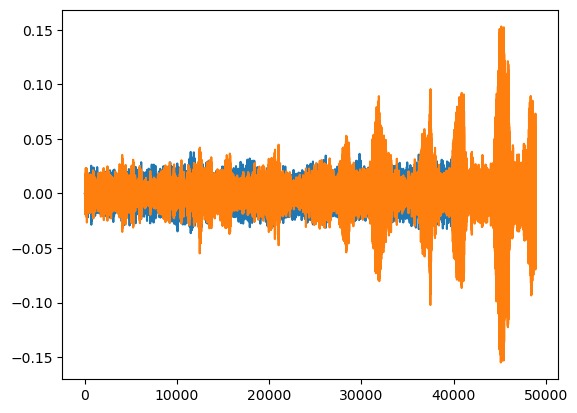

In [7]:
plt.plot(wav)
plt.plot(nwave)
plt.show()

In [8]:
BIRD = "Parsed_Capuchinbird_Clips"
NO_SOUND = "Parsed_Not_Capuchinbird_Clips"
LION = "Pure_Lion"
GUN = "gunshots_version2"

In [9]:
pos1 = tf.data.Dataset.list_files(BIRD+"/*.wav")
pos2 = tf.data.Dataset.list_files(LION+"/*.wav")
pos3 = tf.data.Dataset.list_files(GUN+"/*.wav")
neg = tf.data.Dataset.list_files(NO_SOUND+"/*.wav")

cap = tf.ones(len(pos1),tf.int32)
cap = tf.keras.utils.to_categorical(cap,4)

no_cap = tf.zeros(len(neg),tf.int32)
no_cap = tf.keras.utils.to_categorical(no_cap,4)

lion = np.full(25,2,dtype=int)
lion = tf.convert_to_tensor(lion)
lion = tf.keras.utils.to_categorical(lion,4)
gun = np.full(374,3,dtype=int)
gun = tf.convert_to_tensor(gun)
gun = tf.keras.utils.to_categorical(gun,4)

In [10]:
class_list = ["ambient","capuchin","lion","gun"]

In [11]:
# pos1 = tf.data.Dataset.list_files(YES+"/*.wav")
# pos2 = tf.data.Dataset.list_files(YES[1]+"/*.wav")
# pos3 = tf.data.Dataset.list_files(YES[2]+"/*.wav")
# neg = tf.data.Dataset.list_files(NO+"/*.wav")
pos1.as_numpy_iterator().next()
pos2.as_numpy_iterator().next()
pos3.as_numpy_iterator().next()
# pos3.as_numpy_iterator().next()
positives = tf.data.Dataset.zip((pos1,tf.data.Dataset.from_tensor_slices(cap)))
positives2 = tf.data.Dataset.zip((pos2,tf.data.Dataset.from_tensor_slices(lion)))
positives3 = tf.data.Dataset.zip((pos3,tf.data.Dataset.from_tensor_slices(gun)))
# positives3 = tf.data.Dataset.zip((pos3,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos3)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(no_cap)))
data1=positives.concatenate(positives2)
data2 = data1.concatenate(positives3)
data3=data2.concatenate(negatives)
data3.shuffle(1000).as_numpy_iterator().next()
len(data3)

1210

## Finding the average length of a bird call

In [ ]:
lengths = []
for file in os.listdir("gunshots_version2"):
    tensor_wave = get_audio(os.path.join("gunshots_version2",file))
    lengths.append(len(tensor_wave))

In [12]:
lengths
tf.math.reduce_mean(lengths)


NameError: name 'lengths' is not defined

In [13]:
def preprocess(file_path,label):
    wav = get_audio(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
    wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)#preprocessing the spectrogram
    spectrogram = tf.abs(spectrogram)#remove the negatives
    spectrogram = tf.expand_dims(spectrogram,axis=2)#adding a channel dim for the cnn
    return spectrogram,label

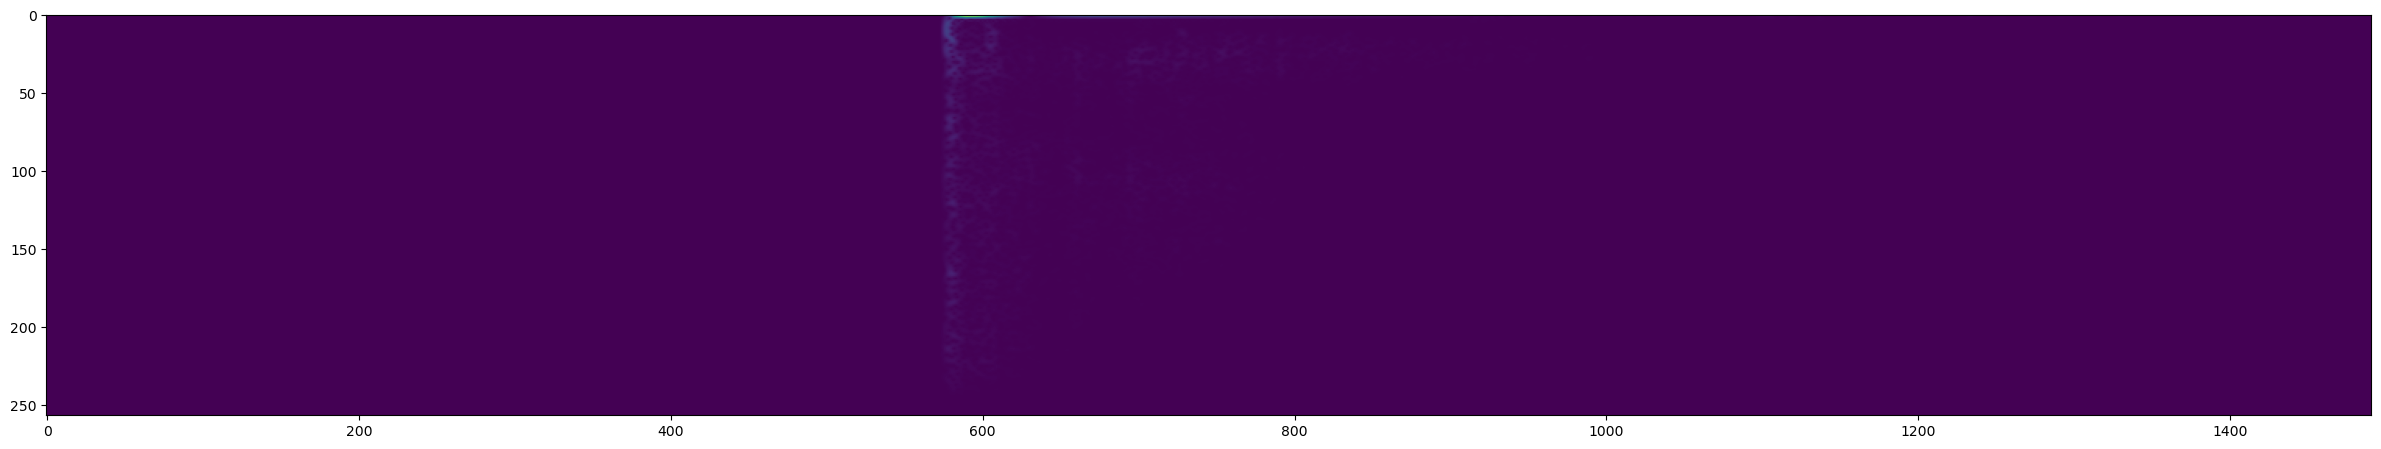

In [14]:
filepath,label = positives3.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectogram,label = preprocess(filepath,label)
spectogram  
plt.figure(figsize=(30,30))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

# Creating Data Pipeline

In [15]:
data3.shuffle(1000).as_numpy_iterator().next()

(b'Parsed_Not_Capuchinbird_Clips\\birds-singing-in-forest-sounds-21.wav',
 array([1., 0., 0., 0.], dtype=float32))

In [16]:
data3 = data3.map(preprocess)
data3 = data3.cache()
data3 = data3.shuffle(buffer_size=1000)
data3 = data3.batch(16)
data3 = data3.prefetch(8)


In [17]:
print(0.7*len(data3))
print(len(data3))
train_size = data3.take(54)
test_size = data3.skip(54).take(22)

53.199999999999996
76


In [18]:
samples,labels = train_size.as_numpy_iterator().next()
print(samples.shape)
len(labels)


(16, 1491, 257, 1)


16

# Building CNN

In [19]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Dense,Flatten,MaxPool2D
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Conv2D,Dense,Flatten,MaxPool2D,BatchNormalization,Dropout

model = Sequential()
model.add(Conv2D(16,(3,3),activation="relu",input_shape=(1491,257,1)))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Conv2D(16,(3,3),activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(16,(3,3),activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(16,(3,3),activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(4,activation="softmax"))

model.compile('Adam',loss="categorical_crossentropy",metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.Accuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 744, 127, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                        

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=40)
hist = model.fit(train_size,epochs=100,validation_data=test_size,callbacks=[callback])

Epoch 1/100
54/54 [==============================] - 43s 160ms/step - loss: 0.6726 - recall: 0.7708 - precision: 0.8506 - accuracy: 0.0052 - val_loss: 0.6867 - val_recall: 0.6561 - val_precision: 0.9913 - val_accuracy: 0.0000e+00
Epoch 2/100
54/54 [==============================] - 7s 137ms/step - loss: 0.1257 - recall: 0.9549 - precision: 0.9672 - accuracy: 0.0469 - val_loss: 0.3999 - val_recall: 0.8439 - val_precision: 0.8822 - val_accuracy: 0.0051
Epoch 3/100
54/54 [==============================] - 7s 138ms/step - loss: 0.0763 - recall: 0.9699 - precision: 0.9790 - accuracy: 0.0761 - val_loss: 0.2227 - val_recall: 0.9191 - val_precision: 0.9550 - val_accuracy: 0.0166
Epoch 4/100
54/54 [==============================] - 7s 138ms/step - loss: 0.1008 - recall: 0.9664 - precision: 0.9755 - accuracy: 0.1036 - val_loss: 0.2474 - val_recall: 0.8902 - val_precision: 0.9249 - val_accuracy: 0.0542
Epoch 5/100
54/54 [==============================] - 7s 137ms/step - loss: 0.0734 - recall: 0.9

In [21]:
hist.history
model.save("maybefinal.h5")

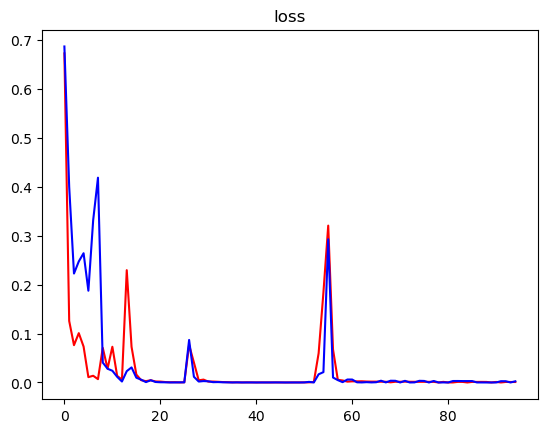

In [22]:
plt.title("loss")
plt.plot(hist.history["loss"],"r")
plt.plot(hist.history["val_loss"],"b")
plt.show()


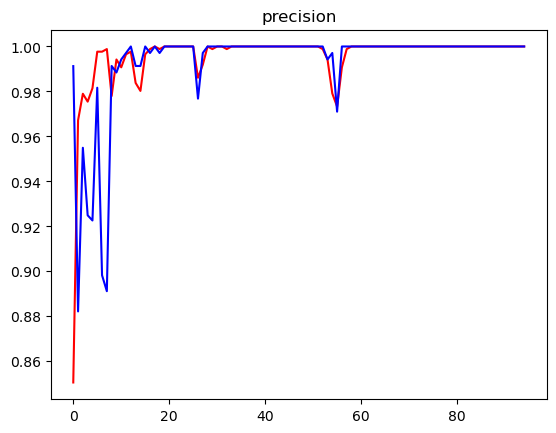

In [23]:
plt.title("precision")
plt.plot(hist.history["precision"],"r")
plt.plot(hist.history["val_precision"],"b")
plt.show()

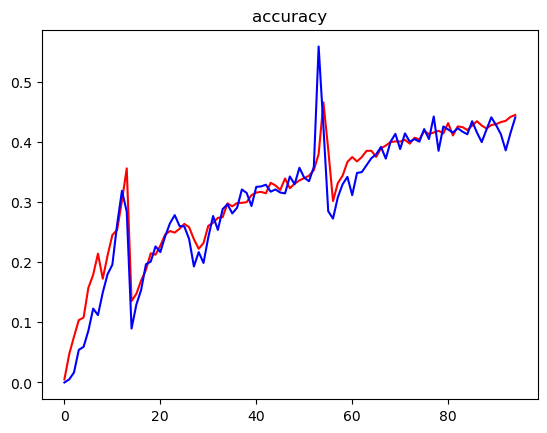

In [24]:
plt.title("accuracy")
plt.plot(hist.history["accuracy"],"r")
plt.plot(hist.history["val_accuracy"],"b")
plt.show()

In [28]:
X_test,y_test = test_size.as_numpy_iterator().next()
print(X_test)
# y_test.shape
test_size

[[[[1.89395575e-03]
   [3.99865769e-03]
   [7.76740303e-03]
   ...
   [1.11004938e-05]
   [3.20308027e-06]
   [3.36673111e-07]]

  [[1.66557287e-03]
   [2.77062599e-03]
   [7.31641008e-03]
   ...
   [1.06352818e-05]
   [3.97609392e-06]
   [1.16252340e-06]]

  [[1.84923946e-03]
   [1.56825525e-03]
   [7.58916698e-03]
   ...
   [6.13531029e-06]
   [3.34212245e-06]
   [3.90061177e-06]]

  ...

  [[1.90803781e-04]
   [2.90833483e-03]
   [5.27546229e-03]
   ...
   [1.11768704e-05]
   [4.92200252e-06]
   [3.11061740e-07]]

  [[3.13047320e-04]
   [2.63056532e-03]
   [5.05257817e-03]
   ...
   [8.62738125e-06]
   [6.41940824e-06]
   [3.46824527e-06]]

  [[7.68356957e-04]
   [3.90307326e-03]
   [5.53626940e-03]
   ...
   [2.13488784e-06]
   [6.97457062e-06]
   [4.32785600e-06]]]


 [[[2.12923344e-03]
   [4.88576386e-03]
   [2.63823615e-03]
   ...
   [5.81040422e-06]
   [3.60922354e-06]
   [2.09081918e-06]]

  [[5.85052744e-03]
   [4.49476810e-03]
   [2.72874767e-03]
   ...
   [1.00282896e-05]
 

<TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [29]:
preds = model.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [30]:
preds

array([[9.99999762e-01, 1.93167637e-07, 2.12840982e-14, 1.04401716e-10],
       [1.00000000e+00, 7.17633160e-35, 1.51561572e-36, 1.10680875e-33],
       [5.88881022e-34, 0.00000000e+00, 1.69215440e-27, 1.00000000e+00],
       [6.84464621e-28, 3.22872902e-30, 6.83012691e-33, 1.00000000e+00],
       [4.38616753e-20, 1.00000000e+00, 0.00000000e+00, 7.61607769e-16],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.27661153e-15, 3.96428889e-16, 1.00570952e-19],
       [5.09357042e-23, 3.87707453e-35, 6.02930721e-20, 1.00000000e+00],
       [9.34953161e-04, 3.00076383e-04, 4.03510872e-04, 9.98361528e-01],
       [8.28740376e-05, 9.99864459e-01, 2.08328577e-10, 5.26454023e-05],
       [2.03097015e-18, 1.00000000e+00, 2.25658757e-31, 8.02727861e-19],
       [7.83836972e-33, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [5.55985412e-31, 6.34298868e-32, 3.15257976e-28, 1.00000000e+00],
       [1.00000000e+00, 5.58216996e-38, 8.08759369e

class_list = ["ambient","capuchin","lion","gun"]


In [32]:
yhat = [class_list[np.argmax(a)] for a in preds ]
# tf.math.reduce_sum(yhat)
yhat

['ambient',
 'ambient',
 'gun',
 'gun',
 'capuchin',
 'ambient',
 'ambient',
 'gun',
 'gun',
 'capuchin',
 'capuchin',
 'gun',
 'gun',
 'ambient',
 'capuchin',
 'ambient']

In [33]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# tf.math.reduce_sum(y_test)

In [34]:
y_test.astype(int)

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [35]:
def load_mp3_16k(filepath):
    res = tfio.audio.AudioIOTensor(filepath)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor,axis=1)/2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate,dtype=tf.int64)   
    wav = tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav


In [105]:
mp3 = "W_Forest/afternoon-birds-song-in-forest-3.wav"
wav = load_mp3_16k(mp3)
# audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

In [106]:
# samples,index = audio_slices.as_numpy_iterator().next()
# samples.shape
# len(audio_slices)

In [107]:
def preprocessmp3(sample,index):
    sample = sample[0]
    zero_padding = tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
    wav = tf.concat([zero_padding,sample],0)
    spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)#preprocessing the spectrogram
    spectrogram = tf.abs(spectrogram)#remove the negatives
    spectrogram = tf.expand_dims(spectrogram,axis=2)#adding a channel dim for the cnn
    return spectrogram


In [108]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
audio_slices = audio_slices.map(preprocessmp3)
audio_slices=audio_slices.batch(1)

In [109]:
yhat = model.predict(audio_slices)
print(len(yhat))
predictions = [(class_list[np.argmax(a)],(i+1)*3) for i,a in enumerate(yhat)]

1/1 [==============================] - 0s 263ms/step
1


In [110]:
len(predictions)#60
# yhat

1

In [111]:
# yhat = [key for key,group in groupby(yhat)]
# yhat

In [112]:
# calls = tf.math.reduce_sum(yhat)
# calls

In [113]:
predictions

[('ambient', 3)]